# Stock Price Prediction Using Yahoo Finance

# Import necessary libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Input
import yfinance as yf

# Step 1: Load Stock Data

In [3]:
data = yf.download('AAPL', '2015-01-01', '2023-01-01')

[*********************100%***********************]  1 of 1 completed


# Step 2: Exploratory Data Analysis (EDA)

Dataset Head:
 Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2015-01-02  24.347170  24.817055  23.906234  24.805920  212818400
2015-01-05  23.661272  24.195739  23.474210  24.115569  257142000
2015-01-06  23.663506  23.924058  23.300513  23.725860  263188400
2015-01-07  23.995314  24.095525  23.761484  23.872831  160423600
2015-01-08  24.917273  24.975174  24.206877  24.324906  237458000

Dataset Info:

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2014 entries, 2015-01-02 to 2022-12-30
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, AAPL)   2014 non-null   float64
 1   (High, AAPL)    2014 non-null   float64
 2   (Low, AAPL)     2014 non-null   float64
 3   (Open, AAPL)    2014 non-null   float64
 4   (Volume, AAPL)  2014 non-null   int64  
dt

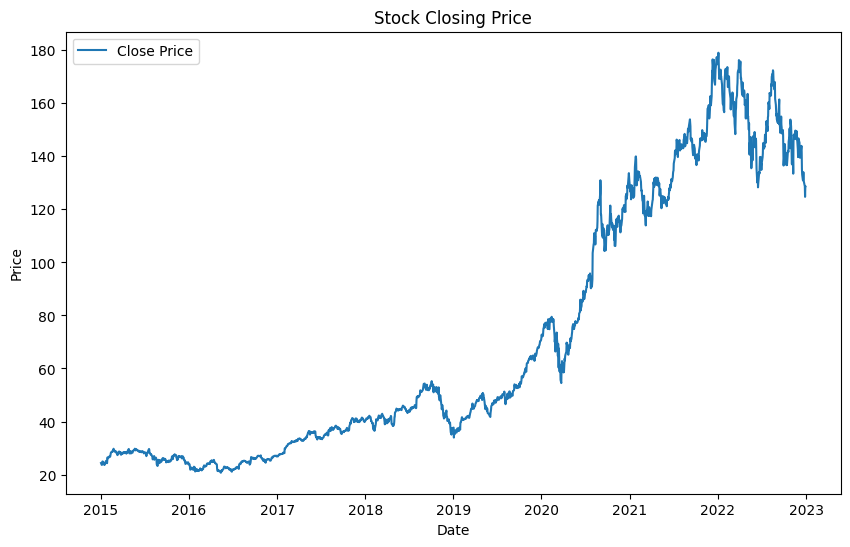

In [4]:
print("Dataset Head:\n", data.head())
print("\nDataset Info:\n")
data.info()
print("\nSummary Statistics:\n", data.describe())

# Plot closing price
plt.figure(figsize=(10, 6))
plt.plot(data['Close'], label='Close Price')
plt.title('Stock Closing Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Step 3: Data Preprocessing

In [5]:
"""Prepare data for LSTM model: scale and create sequences."""
# Use the 'Close' column for prediction
close_prices = data['Close'].values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices.reshape(-1, 1))

# Create sequences
sequence_length = 60
X, y = [], []
for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i, 0])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # Reshape for LSTM

# Step 4: Build the LSTM Model

In [6]:
"""Build and compile an LSTM model."""
model = Sequential()
model.add(Input(shape=(60, 1)))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dense(units=25))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Step 5: Train the Model

In [7]:
"""Train the LSTM model."""
epochs = 10
batch_size = 32
model.fit(X, y, epochs=epochs, batch_size=batch_size)


Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1472
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0973
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0960
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0977
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0985
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1005
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0974
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0948
Epoch 9/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0948
Epoch 10/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1005


# Step 6: Model Evaluation and Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


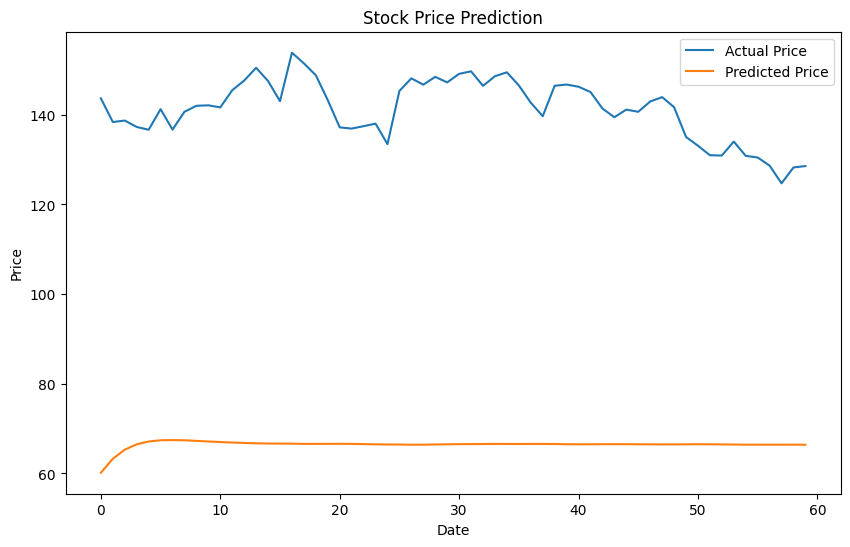

In [8]:
test_data = data['Close'][-(sequence_length + 1):].values
test_scaled = scaler.transform(test_data.reshape(-1, 1))
X_test = []
for i in range(sequence_length, len(test_scaled)):
    X_test.append(test_scaled[i-sequence_length:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))

plt.figure(figsize=(10, 6))
plt.plot(data['Close'].values[-len(predictions):], label='Actual Price')
plt.plot(predictions, label='Predicted Price')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()